In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
import plotly.express as px
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [2]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_35712\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_35712\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_35712\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [3]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [4]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [5]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)
data = data.dropna()

In [6]:
energies = ['biomass', 'hard_coal', 'oil', 'geothermal', 'other', 'solar', 'waste',
       'wind','total_aggregated', 'hydro_tot', 'gas_tot']

# 24h ARIMA

In [7]:
# Facciamo test di stazionarietà classico col DF
df_stationarityTest = adfuller(data['total_aggregated'])

# Check del p-value: è decisamente sotto 0.05, quindi la serie è stazionaria, no unit root
print('ADF Statistic: %f' % df_stationarityTest[0])
print('p-value: %f' % df_stationarityTest[1])
print('Critical Values:')
for key, value in df_stationarityTest[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.859049
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [8]:
for energy in energies:
    # Facciamo test di stazionarietà classico col DF
    df_stationarityTest = adfuller(data[energy])

    # Check del p-value: è decisamente sotto 0.05, quindi la serie è stazionaria, no unit root
    print(f'ADF for {energy}')
    print('ADF Statistic: %f' % df_stationarityTest[0])
    print('p-value: %f' % df_stationarityTest[1])
    print('Critical Values:')
    for key, value in df_stationarityTest[4].items():
      print('\t%s: %.3f' % (key, value))

ADF for biomass
ADF Statistic: -3.569681
p-value: 0.006368
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for hard_coal
ADF Statistic: -10.327294
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for oil
ADF Statistic: -17.796542
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for geothermal
ADF Statistic: -15.111945
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for other
ADF Statistic: -5.546174
p-value: 0.000002
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for solar
ADF Statistic: -17.781844
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for waste
ADF Statistic: -15.567404
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for wind
ADF Statistic: -22.342991
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for total_aggregated
ADF Statistic: -20.859049
p-value: 0.000000
Critical Values:
	1%: -3.430


c:\Users\loren\anaconda3\envs\global_packs\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


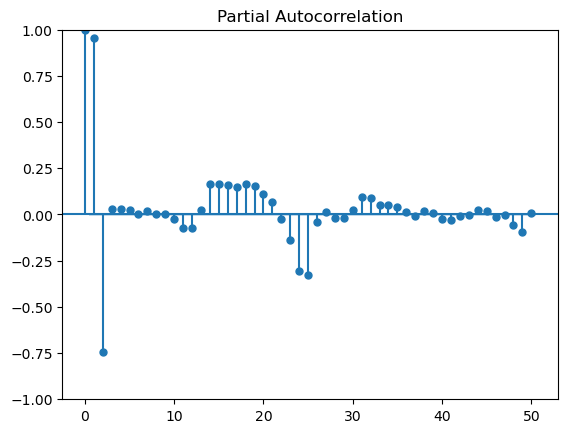

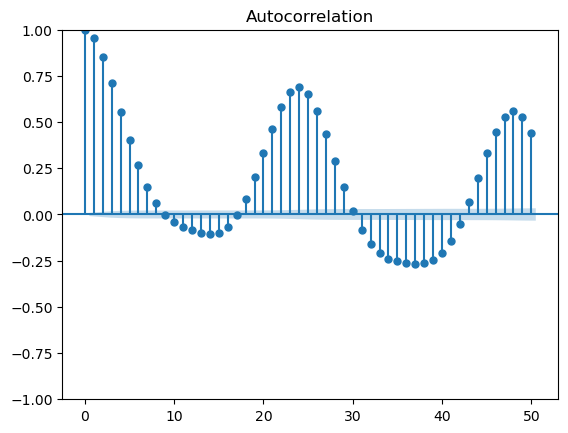

In [9]:
# Ora trovare l'ordine del nostro AR
# Plotto il grafico delle autocorrelazioni per determinare
# quando decade la dipendenza col passato
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(data['total_aggregated'], lags=50)

acf = plot_acf(data['total_aggregated'], lags=50)

# dal grafico si nota che la dipendenza col passato decade dopo il primo lag, quindi useremo un AR(1)

In [10]:
diff_data = data.total_aggregated.diff()
diff_data = diff_data.fillna(0)

c:\Users\loren\anaconda3\envs\global_packs\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


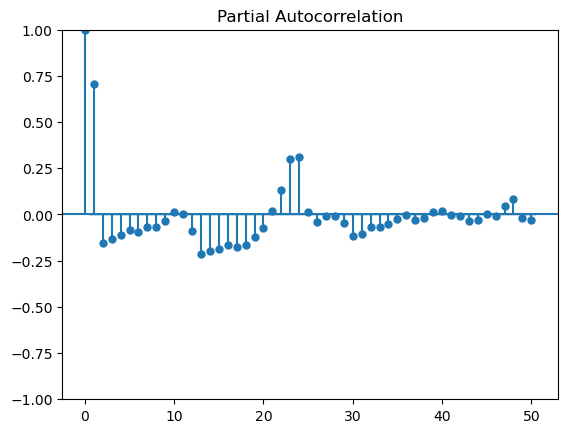

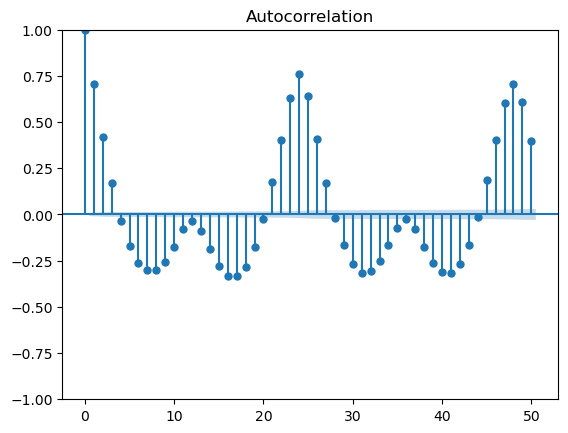

In [11]:
diff_pacf = plot_pacf(diff_data, lags=50)
diff_acf = plot_acf(diff_data, lags=50)

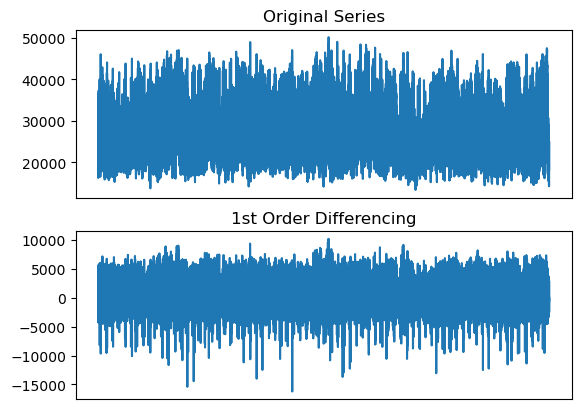

In [12]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(data.total_aggregated); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data.total_aggregated.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)

In [13]:
n_train = 35087
n_test = int(len(data)-n_train)

def arima_data_generator(data, feature):
    series = data['total_aggregated'].values
    train_array, test_array = series[:n_train], series[n_train:]
    # Replace NaN values with the mean of the series
    train_array[np.isnan(train_array)] = np.mean(train_array)
    test_array[np.isnan(test_array)] = np.mean(test_array)

        #train_df, test_df = pd.DataFrame(train_array), pd.DataFrame(test_array)

    return train_array, test_array

train, test = arima_data_generator(data, 'total_aggregated')


In [44]:
#def fit_arima_model(data):
#    model = ARIMA(data, order=(2, 0, 0))
#    model_fit = model.fit(start_params=[0,0,0])
#    return model_fit

Test RMSE: 6858.873


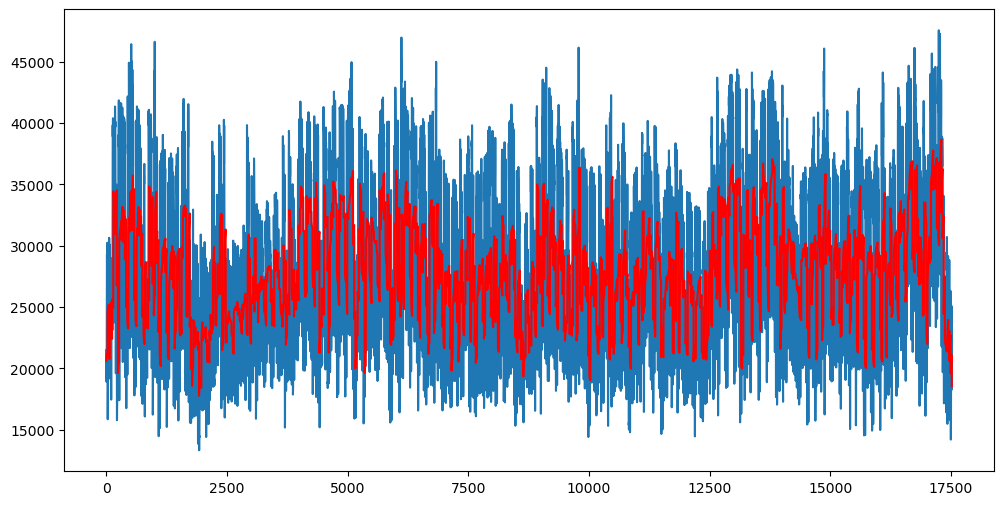

In [16]:
# train autoregression
ar_orders = [1]
for ar_order in ar_orders:
    history = [x for x in train]
    predictions = list()
    window_size = 24
    for i in range(0, len(test), window_size):
        t_end = i + 24
        if t_end > len(test):
            t_end = len(test)
        test_block = test[i:t_end]
        model = ARIMA(history[-window_size:], order=(ar_order,0,0))
        model_fit = model.fit()
        output = model_fit.forecast(steps=len(test_block))
        yhat = output
        if isinstance(yhat, (int, float)):
            yhat = [yhat]
        predictions.extend(yhat)
        obs = test_block
        history.extend(obs)
        #for z in zip(yhat, obs):
        #    print('predicted=%s, expected=%s' % z)
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(12,6))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

In [ ]:
for energy in energies:

    n_train = 35087
    n_test = int(len(data)-n_train)
    
    series = data[energy].values
    train, test = series[:n_train], series[len(series)-n_train-1:]
    # Replace NaN values with the mean of the series
    train[np.isnan(train)] = np.mean(train)
    test[np.isnan(test)] = np.mean(test)

    # train autoregression
    ar_orders = [1, 2]
    for ar_order in ar_orders:
        history = [x for x in train]
        predictions = list()
        window_size = 24
        for i in range(0, len(test), window_size):
            t_end = i + 24
            if t_end > len(test):
                t_end = len(test)
            test_block = test[i:t_end]
            model = ARIMA(history[-window_size:], order=(ar_order,0,0))
            model_fit = model.fit()
            output = model_fit.forecast(steps=len(test_block))
            yhat = output
            if isinstance(yhat, (int, float)):
                yhat = [yhat]
            predictions.extend(yhat)
            obs = test_block
            history.extend(obs)
            #for z in zip(yhat, obs):
            #    print('predicted=%s, expected=%s' % z)
        rmse = sqrt(mean_squared_error(test, predictions))
        print(f'Test RMSE for {energy} with AR{ar_order}: %.3f' % rmse)
        # plot
        pyplot.figure(figsize=(12,6))
        pyplot.plot(test)
        pyplot.plot(predictions, color='orange')
        pyplot.show()
    